## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [425]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [426]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [427]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

## Визуализируем исходные данные

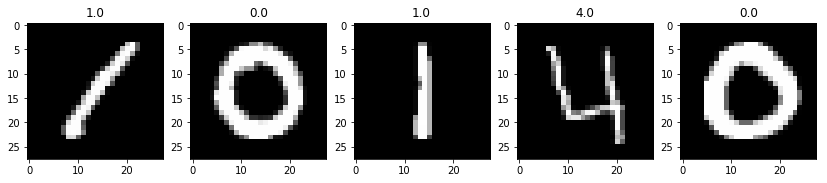

In [428]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [429]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [430]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [431]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [432]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

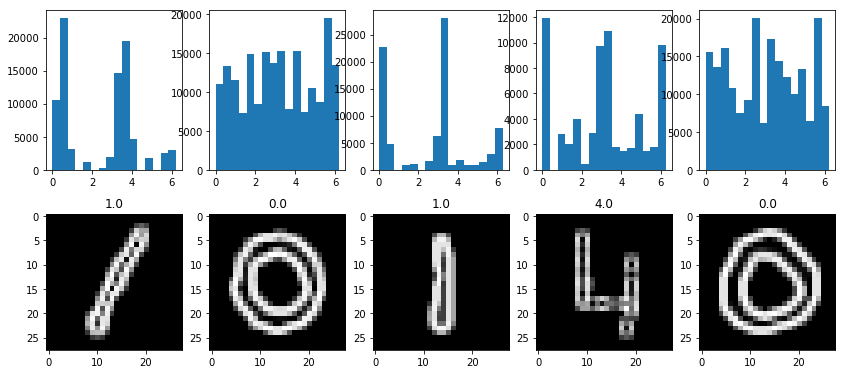

In [371]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов для всего изображения

In [461]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [462]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [463]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [464]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [465]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2, random_state=42)

## Построим KNN из пакета OpenCV

In [487]:
# Feature set containing (x,y) values of 25 known/training data
trainData = x_train.astype(np.float32)

# Labels each one either Red or Blue with numbers 0 and 1
responses = y_train.astype(np.float32)

knn = cv2.ml.KNearest_create()
knn.train(trainData,cv2.ml.ROW_SAMPLE, responses)

True

In [494]:
retval, results = knn.predict(x_val.astype(np.float32))
print('Accuracy: %s' % accuracy_score(y_val, results))

Accuracy: 0.602142857143


Тренируемна полных данных и делаем предсказание для Kaggle

In [ ]:
knn.train(train_hist.astype(np.float32),cv2.ml.ROW_SAMPLE, train_label.astype(np.float32))
retval, results = knn.predict(test_hist.astype(np.float32))

In [ ]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(results, 1):
        dst.write('%s,%s\n' % (i, p[0]))

__Качество на Kaggle для KNN: 0.61543__

## Гистограммы градиентов для изображения, разбитого на 4 части

In [512]:
train_hist = np.zeros((len(train_img), 64))
for i in range(len(train_img)):
    hist_up_r, borders_up_r = np.histogram(train_theta[i][:14,:14],
                                 bins=16,
                                 range=(0.,  2*np.pi),
                                 weights=train_g[i][0:14,:14])
    hist_down_r, borders_down_r = np.histogram(train_theta[i][14:,:14],
                                 bins=16,
                                 range=(0.,  2*np.pi),
                                 weights=train_g[i][14:,:14])    
    hist_up_l, borders_up_l = np.histogram(train_theta[i][:14,14:],
                                 bins=16,
                                 range=(0.,  2*np.pi),
                                 weights=train_g[i][0:14,14:])
    hist_down_l, borders_down_l = np.histogram(train_theta[i][14:,14:],
                                 bins=16,
                                 range=(0.,  2*np.pi),
                                 weights=train_g[i][14:,14:])       

    train_hist[i] = np.hstack([hist_up_r, hist_down_r,hist_up_l, hist_down_l])

In [513]:
test_hist = np.zeros((len(test_img), 64))
for i in range(len(test_img)):
    hist_up_r, borders_up_r = np.histogram(test_theta[i][:14,:14],
                                 bins=16,
                                 range=(0., 2*np.pi),
                                 weights=test_g[i][:14,:14])
    hist_down_r, borders_down_r = np.histogram(test_theta[i][14:,:14],
                                 bins=16,
                                 range=(0., 2*np.pi),
                                 weights=test_g[i][14:,:14])    
    hist_up_l, borders_up_l = np.histogram(test_theta[i][:14,14:],
                                 bins=16,
                                 range=(0., 2*np.pi),
                                 weights=test_g[i][:14,14:])
    hist_down_l, borders_down_l = np.histogram(test_theta[i][14:,14:],
                                 bins=16,
                                 range=(0., 2*np.pi),
                                 weights=test_g[i][14:,14:])        

    test_hist[i] = np.hstack([hist_up_r, hist_down_r,hist_up_l, hist_down_l])

Нормализуем и разбиваем на тест и трейн

In [519]:
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2, random_state=42)

## Вычисляем центроиды каждого из 10 классов

In [520]:
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)

In [521]:
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

## Находим ближайший центройд для валидации

In [522]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

## Оцениваем качество решение на валидационной выборке

In [523]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.826666666667


In [524]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.89      0.91      0.90       816
        1.0       0.89      0.92      0.90       909
        2.0       0.85      0.84      0.85       846
        3.0       0.77      0.83      0.80       937
        4.0       0.88      0.76      0.81       839
        5.0       0.89      0.87      0.88       702
        6.0       0.86      0.89      0.88       785
        7.0       0.86      0.77      0.81       893
        8.0       0.67      0.79      0.73       835
        9.0       0.77      0.69      0.72       838

avg / total       0.83      0.83      0.83      8400



In [525]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[744   4  11  10  14   5   5   2  18   3]
 [  0 835   5   0   5   0   3   8  47   6]
 [  7   6 710  64   8   2   9   9  25   6]
 [  9   0  31 782   1  39   4  12  40  19]
 [  4  22  13   3 639   0  67   3  35  53]
 [  2   1   1  50   1 610   7   3  24   3]
 [ 18   9   0   1  14   1 702   0  40   0]
 [  5  31  40  23   3   0   0 686  32  73]
 [ 27  17  18  35  12  27  18   7 661  13]
 [ 20  17   2  49  33   4   4  68  66 575]]


## Предсказания на тестовыйх данных

In [526]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

## Визуализируем предсказания

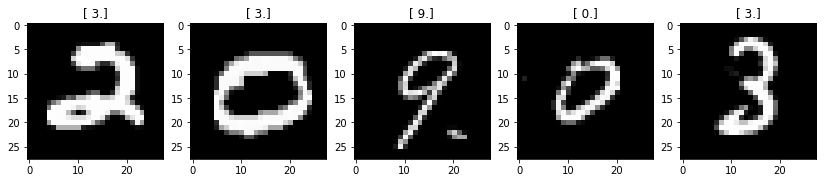

In [527]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % results[i - 1]);

## Готовим файл для отправки

In [528]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

### Качество на Kaggle

* Оригинальный score тетрадки: 0.41700
* __KNN__ на единой гистограмме: __0.61543__
* __Ближайший центроид__ на 4-х гистограммах для частей изображения: __0.82029__